# Wildfire Prediction


#### Tim Rolston #V00920780, Valeriya Savchenko #V00920780

## Our Goal

In this notebook, we explore different data mining methods to clean, train, and test a dataset to create a model that can accurately predict the likehood of wildfires. 

The model will classify whether or not a fire will occur.
Using Linear Regression with a threshold of 0.4, we trained the model to classify a fire as "Fire!" and "No Fire".

We used a threshold of 0.4 because even though a fire may not start at a 0.4 likehood rating, the area is still highly prone to a fire and thus, it needs to be closely monitored. Anything below 0.4, can be classified as No Fire until features change and the model is run again on the changed features.

## Building a Wildfire Prediction

There are many ways to train a model to be able to predict wildfires in a given area. Some methods include using a rating system called "forest fire weather index" which is a mathematical equation that uses daily weather variables to calcuate the probability of a forest fire occuring. Another method to training an accurate wildfire prediction model uses multiple sources of satellite imaging collected from NASA's MODIS imaging system to gain insights into determining if an area has a high risk of a wildfire occuring. Originally we were interested in completing a model using MODIS data based off of 3 main sources; thermal anomalies, leaf area index, and surface temperature, similarily to how they do in this article https://www.sciencedirect.com/science/article/abs/pii/S0301479721024130?via%3Dihub. We later realized that the satellite imaging data is both hard to access remotely and fairly large to download to use locally, just one year of data was over 80Gigs of data.

## A Small Scale Model Using Big Data

We came to find a new dataset, access from NASA's Fire Information for Resource Management System (FIRMS) (https://firms.modaps.eosdis.nasa.gov/download/), that has much more manageable data that still shares insights on wildfires. This data is also collected from MODIS but is processed into numerical data that shows active fire products all around the world. From FIRMS we were able to download data from specific years which contained a file for each country. Since we only wanted to do a sample size of what can be done to manipulate wildfire data on a larger scale we chose to focus on using data from Canada, collected in 2021. This year in particular was chosen because we noticed there was a particular influx in wildfires that year compared to other years around it via http://nfdp.ccfm.org/en/data/fires.php. It is important to note this information as the premise of the model is biased in its own data, by only having data collected from a year high in wildfires, ideally we would also use data from other years low and medium in wildfires. This means that it is easy to overfit our data when comparing the model to real instances. In order to prevent this, we only compare the accuracy of this wildfire prediction model to wildfires that happened in 2021, otherwise we would be poorly representing the ability of this model. This is why we can consider our model to be a "small scale model" that can predict wildfires in the year 2021, that uses big data collected from this year.

### Get the dataset

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

## About the data

Below shows the columns that the MODIS data contains. Latitude and longitude representing the location, brightness  

In [2]:

wildfires = pd.read_csv("modis_2021_Canada.csv")

wildfires.head()

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,type
0,54.8753,-117.4533,321.9,1.1,1.0,2021-01-01,522,Terra,MODIS,91,6.03,266.1,0.0,N,0
1,54.2008,-118.9019,313.9,1.2,1.1,2021-01-01,522,Terra,MODIS,88,6.03,267.7,23.4,N,0
2,55.3087,-111.7090,313.8,2.4,1.5,2021-01-02,1934,Terra,MODIS,0,6.03,265.3,67.6,D,0
3,54.4509,-107.1336,305.0,4.0,1.9,2021-01-02,1934,Terra,MODIS,34,6.03,265.1,94.0,D,0
4,54.4552,-107.1247,322.5,4.0,1.9,2021-01-02,1934,Terra,MODIS,0,6.03,265.8,197.2,D,0


In [3]:
wildfires.isnull().sum()

latitude      0
longitude     0
brightness    0
scan          0
track         0
acq_date      0
acq_time      0
satellite     0
instrument    0
confidence    0
version       0
bright_t31    0
frp           0
daynight      0
type          0
dtype: int64

In [4]:
wildfires.describe()

,latitude,longitude,brightness,scan,track,acq_time,confidence,version,bright_t31,frp,type
count,97100.000000,97100.000000,97100.000000,97100.000000,97100.000000,97100.000000,97100.000000,9.710000e+04,97100.000000,97100.000000,97100.000000
mean,53.557203,-109.326503,333.503459,1.670557,1.229398,1404.042894,67.413913,6.030000e+00,294.314910,108.334157,0.004985
std,3.968219,12.862361,28.765267,0.866015,0.260027,668.912790,30.852951,1.494901e-11,9.833665,281.002078,0.099721
min,42.047000,-140.984700,300.000000,1.000000,1.000000,141.000000,0.000000,6.030000e+00,264.400000,0.000000,0.000000
25%,50.855600,-120.871800,314.000000,1.100000,1.000000,607.000000,49.000000,6.030000e+00,289.000000,17.700000,0.000000
50%,52.260300,-105.455850,326.000000,1.300000,1.100000,1812.000000,75.000000,6.030000e+00,294.500000,37.800000,0.000000
75%,55.465825,-96.462950,344.100000,1.900000,1.400000,1943.000000,95.000000,6.030000e+00,300.000000,91.400000,0.000000
max,68.400800,-54.819900,507.900000,4.800000,2.000000,2311.000000,100.000000,6.030000e+00,400.100000,12808.400000,2.000000


### Remove 'instrument' and 'version' from the dataset as they arent useful

In [5]:
wildfires.drop('instrument', axis=1, inplace=True)
wildfires.drop('version', axis=1, inplace=True)
wildfires.head()

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,confidence,bright_t31,frp,daynight,type
0,54.8753,-117.4533,321.9,1.1,1.0,2021-01-01,522,Terra,91,266.1,0.0,N,0
1,54.2008,-118.9019,313.9,1.2,1.1,2021-01-01,522,Terra,88,267.7,23.4,N,0
2,55.3087,-111.7090,313.8,2.4,1.5,2021-01-02,1934,Terra,0,265.3,67.6,D,0
3,54.4509,-107.1336,305.0,4.0,1.9,2021-01-02,1934,Terra,34,265.1,94.0,D,0
4,54.4552,-107.1247,322.5,4.0,1.9,2021-01-02,1934,Terra,0,265.8,197.2,D,0


### Change 'satellite' and 'daynight' values to integers

In [6]:
wildfires['satellite'] = wildfires['satellite'].astype('category').cat.codes
wildfires['daynight'] = wildfires['daynight'].astype('category').cat.codes
wildfires['month'] = wildfires['acq_date'].apply(lambda x:int(x.split('-')[1]))
wildfires.drop('acq_date', axis=1, inplace=True)
wildfires.head()

,latitude,longitude,brightness,scan,track,acq_time,satellite,confidence,bright_t31,frp,daynight,type,month
0,54.8753,-117.4533,321.9,1.1,1.0,522,1,91,266.1,0.0,1,0,1
1,54.2008,-118.9019,313.9,1.2,1.1,522,1,88,267.7,23.4,1,0,1
2,55.3087,-111.7090,313.8,2.4,1.5,1934,1,0,265.3,67.6,0,0,1
3,54.4509,-107.1336,305.0,4.0,1.9,1934,1,34,265.1,94.0,0,0,1
4,54.4552,-107.1247,322.5,4.0,1.9,1934,1,0,265.8,197.2,0,0,1


In [7]:
wildfires.corr()

,latitude,longitude,brightness,scan,track,acq_time,satellite,confidence,bright_t31,frp,daynight,type,month
latitude,1.000000,-0.307643,0.032445,0.035222,0.038626,0.082573,0.036753,-0.052645,-0.018700,0.019916,-0.087393,-0.108377,0.073000
longitude,-0.307643,1.000000,0.006891,-0.027327,-0.028239,-0.048188,-0.033966,-0.150344,0.102708,-0.026073,-0.067138,0.093504,-0.135966
brightness,0.032445,0.006891,1.000000,-0.066879,-0.065368,0.228201,-0.088433,0.397022,0.600865,0.653885,-0.235988,-0.042871,-0.080730
scan,0.035222,-0.027327,-0.066879,1.000000,0.983855,0.077492,-0.019243,-0.094234,-0.111862,0.231463,-0.085997,-0.018168,-0.045187
track,0.038626,-0.028239,-0.065368,0.983855,1.000000,0.083708,-0.017634,-0.096394,-0.110528,0.228622,-0.092989,-0.018758,-0.045479
acq_time,0.082573,-0.048188,0.228201,0.077492,0.083708,1.000000,-0.459672,-0.153145,0.339904,0.104029,-0.955178,-0.006437,0.010789
satellite,0.036753,-0.033966,-0.088433,-0.019243,-0.017634,-0.459672,1.000000,0.051623,-0.128841,-0.046525,0.283910,0.004633,-0.009546
confidence,-0.052645,-0.150344,0.397022,-0.094234,-0.096394,-0.153145,0.051623,1.000000,0.147495,0.171580,0.172209,-0.040122,-0.000388
bright_t31,-0.018700,0.102708,0.600865,-0.111862,-0.110528,0.339904,-0.128841,0.147495,1.000000,0.340096,-0.359160,-0.015062,-0.223897
frp,0.019916,-0.026073,0.653885,0.231463,0.228622,0.104029,-0.046525,0.171580,0.340096,1.000000,-0.105253,-0.016887,-0.049749


for correlation > 0.1

brightness - frp,
brightness - bright_t31,
brightness - confidence,
scan - track,
scan - frp,
track - frp,
satellite - daylight,
confidence - frp,
confidence - daylight,
bright_t31 - frp


#### Now we want to visualize the correlation
#### We will also drop features with the lowest correlation with "Confidence"

<AxesSubplot:>

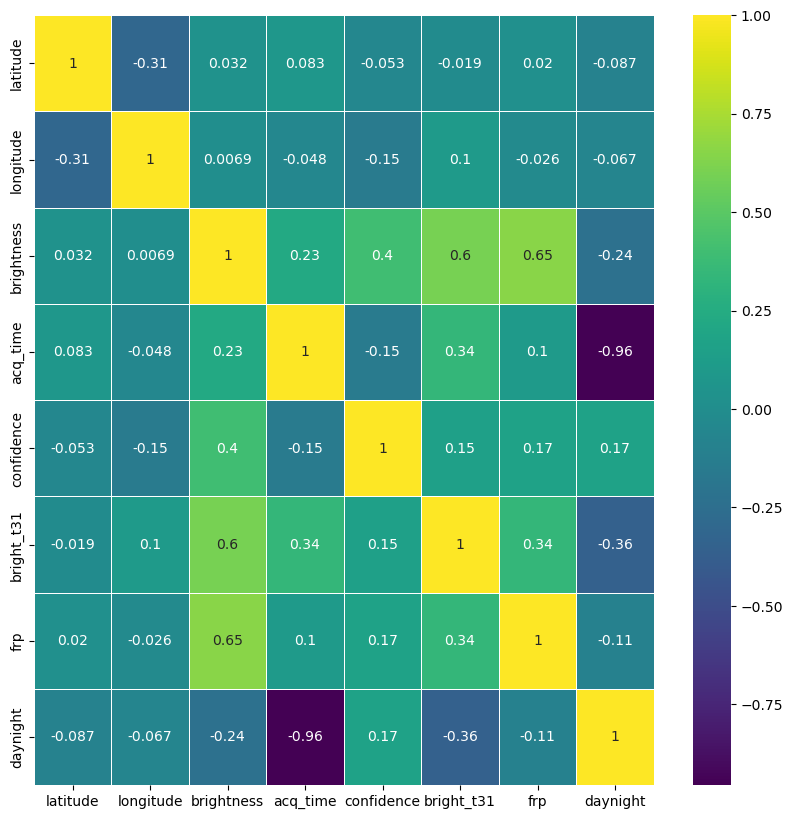

In [8]:
wildfire_clean_set = wildfires.drop(['month', 'type', 'satellite', 'track', 'scan' ], axis = 1)
plt.figure(figsize=(10, 10))
sns.heatmap(wildfire_clean_set.corr(),annot=True,cmap='viridis',linewidths=.5)

### We need to scale the dataset to use the same scale for all features!

In [9]:
from sklearn.preprocessing import MinMaxScaler

def scale_dataset(dataset):
    scaler = MinMaxScaler(feature_range=(0, 1))  # Scale to 0-1
    scaled_dataset = scaler.fit_transform(dataset)
    return scaled_dataset

scaled_dataset = scale_dataset(wildfire_clean_set)

for i, row in enumerate(scaled_dataset[:10]):
    print(row)

[0.48677231 0.2730976  0.10533911 0.17557604 0.91       0.01252763
 0.         1.        ]
[0.46117827 0.25628563 0.06685907 0.17557604 0.88       0.02431835
 0.00182693 1.        ]
[0.50321775 0.33976403 0.06637807 0.82626728 0.         0.00663228
 0.00527779 0.        ]
[0.47066837 0.3928646  0.02405002 0.82626728 0.34       0.00515844
 0.00733893 0.        ]
[0.47083153 0.39296789 0.10822511 0.82626728 0.         0.01031688
 0.01539615 0.        ]
[0.47088465 0.39257446 0.05291005 0.83087558 0.         0.01252763
 0.00142094 0.        ]
[0.48139168 0.27496263 0.04088504 0.78248848 0.67       0.05158438
 0.00177227 0.        ]
[0.47932746 0.27699826 0.05242905 0.78248848 0.71       0.0412675
 0.00185816 0.        ]
[5.13664064e-01 3.28765343e-01 2.64550265e-02 3.76036866e-01
 3.40000000e-01 2.13706706e-02 9.05655663e-04 1.00000000e+00]
[0.40166504 0.28538452 0.11736412 0.90737327 0.73       0.02947679
 0.0045517  0.        ]


In [9]:
from sklearn.preprocessing import MinMaxScaler

def scale_dataset(dataset):
    scaler = MinMaxScaler(feature_range=(0, 1))  # Scale to 0-1
    scaled_dataset = scaler.fit_transform(dataset)
    return scaled_dataset

scaled_dataset = scale_dataset(wildfire_clean_set)

for i, row in enumerate(scaled_dataset[:10]):
    print(row)

[0.48677231 0.2730976  0.10533911 0.17557604 0.91       0.01252763
 0.         1.        ]
[0.46117827 0.25628563 0.06685907 0.17557604 0.88       0.02431835
 0.00182693 1.        ]
[0.50321775 0.33976403 0.06637807 0.82626728 0.         0.00663228
 0.00527779 0.        ]
[0.47066837 0.3928646  0.02405002 0.82626728 0.34       0.00515844
 0.00733893 0.        ]
[0.47083153 0.39296789 0.10822511 0.82626728 0.         0.01031688
 0.01539615 0.        ]
[0.47088465 0.39257446 0.05291005 0.83087558 0.         0.01252763
 0.00142094 0.        ]
[0.48139168 0.27496263 0.04088504 0.78248848 0.67       0.05158438
 0.00177227 0.        ]
[0.47932746 0.27699826 0.05242905 0.78248848 0.71       0.0412675
 0.00185816 0.        ]
[5.13664064e-01 3.28765343e-01 2.64550265e-02 3.76036866e-01
 3.40000000e-01 2.13706706e-02 9.05655663e-04 1.00000000e+00]
[0.40166504 0.28538452 0.11736412 0.90737327 0.73       0.02947679
 0.0045517  0.        ]


### Prepare the dataset
#### We need to split the dataset into the training and the validaiton set

In [10]:
X = scaled_dataset
y = wildfires['confidence']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Do stuff
#### Now that the data has the same scale and is split into the different sets, we can start training the model using Logistic Regression

In [11]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(solver='lbfgs', max_iter=10000)

logreg.fit(X_train, y_train)

y_pred_prob = logreg.predict_proba(X_test)[:, 1]

y_pred = ['Fire!' if prob >= 0.4 else 'No Fire' for prob in y_pred_prob]


#### Now that the model is trained, we want to see how accurate it is!
##### The nxt line transforms the target from the test set into a classified target just like the trained model

In [22]:
y_testy = ['Fire!' if confidence >= 0.4 else 'No Fire' for confidence in y_test] 

TypeError: '>=' not supported between instances of 'str' and 'float'

In [23]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_testy, y_pred)
print("Accuracy:", accuracy)

NameError: name 'y_testy' is not defined